## Inspect PF-Controller Network Outputs

This notebook visualizes the outputs of the trained particle-filter (PF) controller neural network. It illustrates how the network modulates noise parameters, prior weighting, and likelihood correction terms as functions of time. The notebook is intended for inspection and diagnostic purposes and is not part of the core training or evaluation pipeline.

In [1]:
from pathlib import Path
import math


import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from src.models.particle_filter import ParticleFilterMLP

## Task

In [2]:
data_name = "DS03"
perform_name = 'T48'

pf_dir_name = 'pf_perform_normal_net256x256x128x64x32leaky0.05'

## Get netoutput names

In [3]:
from src.models.degradation_models.normal import NormalDegradationModel as NModel
noise_names = NModel.get_state_names() 
netout_names = [p.replace('_raw','_noise') for p in noise_names] +[p.replace('_raw','_prior') for p in noise_names] +['correct_like']+['forget_like']
n_outs = len(netout_names)

## Hyper-Parameters

In [4]:
hidden_dims=[256,256,128,64,32]
activation = nn.LeakyReLU(0.05)

In [5]:
experiment_dir = Path('experiments')/data_name
pf_dir = experiment_dir/pf_dir_name/ perform_name

In [6]:
net = ParticleFilterMLP(state_dim=NModel.state_dim(), hidden_dims=hidden_dims,
                        activation=lambda : activation)

ckpt = torch.load(pf_dir/'checkpoint.pt')
net.load_state_dict(ckpt['model_state'])

net.eval()    # or net.train()

ParticleFilterMLP(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.05)
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.05)
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): LeakyReLU(negative_slope=0.05)
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): LeakyReLU(negative_slope=0.05)
    (8): Linear(in_features=64, out_features=32, bias=True)
    (9): LeakyReLU(negative_slope=0.05)
    (10): Linear(in_features=32, out_features=16, bias=True)
  )
)

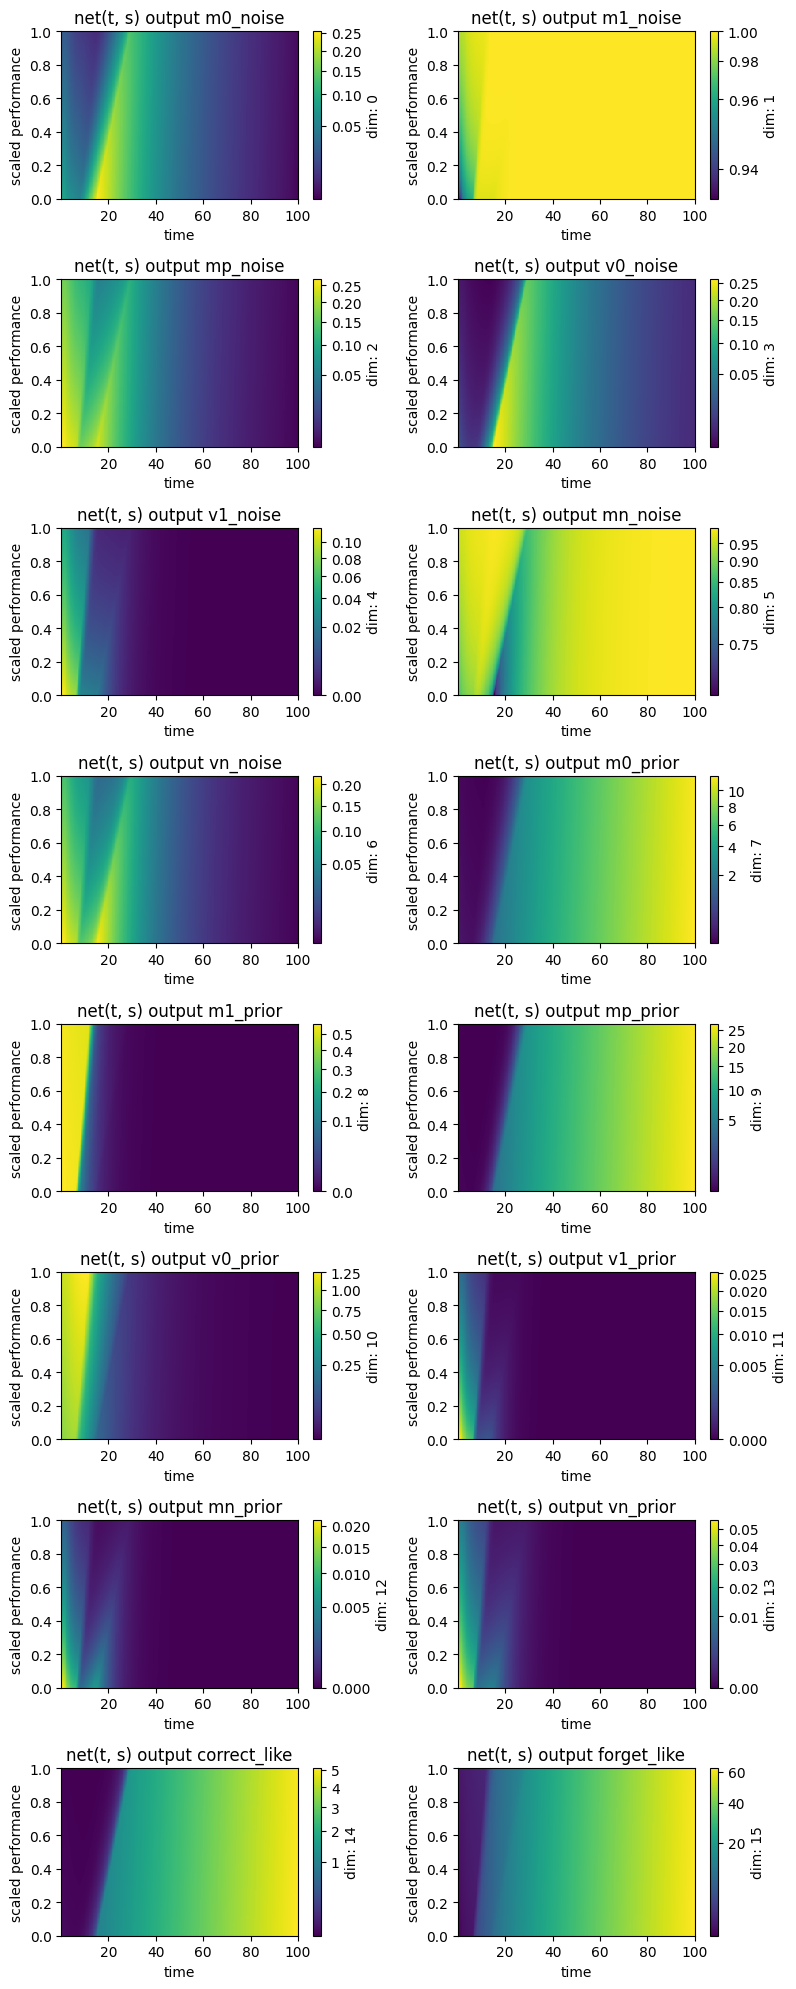

In [7]:
t_grid = np.linspace(0.1, 100, 300)
s_grid = np.linspace(0.0, 1.0, 200)

net.eval()

fig, axes = plt.subplots(math.ceil(n_outs/2), 2, figsize=(8, 20))
vmax = len(noise_names)*[None] +len(noise_names)*[None] + [None,None] 
for i,name in enumerate(netout_names):
	net.plot_output(
		t=t_grid,
		s=s_grid,
		dim=i,
  		vmax=vmax[i],
		ax=axes[i//2, i%2],
		title=f"net(t, s) output {name}",
	)


plt.tight_layout()
plt.show()